# **OK!**

# **Modelo de Sistema de Recomendación - GRUPOREFERENCIA**
# **Algoritmo KerasClassifier**

In [1]:
import os
import psutil

# Memoria
print(f"Memoria total: {psutil.virtual_memory().total / 1e9:.2f} GB")  # Si muestra >16GB → probablemente remoto

# CPU
print(f"Núcleos lógicos: {os.cpu_count()}")  # >8 cores → servidor dedicado

Memoria total: 540.72 GB
Núcleos lógicos: 144


In [2]:
import sklearn, imblearn, scikeras, tensorflow
print("Versión scikit-learn:", sklearn.__version__)       # Debe ser == 1.5.2
print("Versión imbalanced-learn:", imblearn.__version__)  # Debe ser == 0.13.0
print("Versión scikeras:", scikeras.__version__)          # Debe ser == 0.13.0
print("Versión scikeras:", tensorflow.__version__)          # Debe ser == 0.13.0

2025-06-15 23:45:31.142940: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-15 23:45:31.144082: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-15 23:45:31.148829: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-15 23:45:31.159828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750031131.178323 3313216 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750031131.18

Versión scikit-learn: 1.5.2
Versión imbalanced-learn: 0.13.0
Versión scikeras: 0.13.0
Versión scikeras: 2.19.0


In [3]:
import pandas as pd
import numpy as np
import joblib
import random

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import (f1_score,
                             matthews_corrcoef,
                             cohen_kappa_score)
from imblearn.over_sampling import SMOTE

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from collections import Counter

In [5]:
from dav_cas.tools.eva_mod import classification_report_df
from dav_cas.tools.graficos import conf_matrix_normalized_sn

In [6]:
# Semillas para reproducibilidad
SEED = 7
os.environ['PYTHONHASHSEED'] = f'{SEED}'  # Para operaciones hash en Python
np.random.seed(SEED)                   # Semilla para numpy
random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)

In [7]:
basedir = os.getcwd()

## **1- Carga de los datos SB11_SBPro_UDENAR_02_00:**

## **(Data #7)**

In [8]:
CAR_NOM = '02' # Características nominales
CAR_ORD = '00' # Características ordinales

In [9]:
X = pd.read_csv(os.path.join(basedir, f'data/data_icfes/SB11_SBPro/SB11_SBPro_UDENAR_{CAR_NOM}_{CAR_ORD}.csv'))

## **2- Carga los valores de 'y' (GRUPOREFERENCIA):**

In [10]:
y = pd.read_csv(os.path.join(basedir, 'data/data_icfes/SB11_SBPro/y_GRUPOREFERENCIA_clase.csv'))

## **3- Dividir el dataset en entrenamiento y prueba:**

In [11]:
# División estratificada en train (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=SEED)

## **4- Selección de Características:**

In [12]:
%run -i "Selección de características.ipynb"

In [13]:
dic_nom_features = {'00': nominal_features_00,
                    '01': nominal_features_01,
                    '02': nominal_features_02}

In [14]:
dic_ord_features = {'00': dic_car_ord_00,
                    '01': dic_car_ord_01,
                    '02': dic_car_ord_02}

In [15]:
# Características Nominales
nominal_features = dic_nom_features[CAR_NOM]
# Características Ordinales
ordinal_features = list(dic_ord_features[CAR_ORD].keys())
# Características Numéricas
numerical_features = numeric_features

## **5- Configuración del Preprocesamiento:**

In [16]:
preprocessor = ColumnTransformer(
    transformers=[
        # Codificar variables categóricas nominales
        ('nominal', OneHotEncoder(handle_unknown='ignore'), nominal_features),
        # Codificar variables categóricas ordinales
        ('ordinal', OrdinalEncoder(), ordinal_features),
        # Escalar variables numéricas
        ('numerico', RobustScaler(), numerical_features)
    ],
    # remainder='drop'  # Descarta columnas no especificadas (opcional)
    # remainder='passthrough'  # Mantiene las columnas no especificadas
)

## **6- Calcular pesos ANTES de SMOTE (usando y_train original):**

In [17]:
# Especificar class weights
from sklearn.utils.class_weight import compute_class_weight

# Calcular los pesos usando TODAS las clases del dataset original
classes = np.unique(y.values.ravel())
class_weights = compute_class_weight('balanced', 
                                     classes=classes,
                                     y=y_train.values.ravel()) # Pero aplicado solo a los datos de entrenamiento
class_weights_dict = dict(zip(classes, class_weights))

In [18]:
n_classes = len(classes)

## **7- Cálculo de dimensión de entrada:**

In [19]:
preprocessor.fit(X_train)
Xt = preprocessor.transform(X_train)
input_dim = Xt.shape[1]
print(f"Dimensión de entrada después de preprocesamiento: {input_dim}")

Dimensión de entrada después de preprocesamiento: 24


## **8- Función de creación del modelo con tf.keras:**

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam, Nadam, SGD, RMSprop

def create_model(
    input_dim,
    output_dim,
    num_neurons,    # Ahora puede ser una lista (ej: [128, 64])
    dropout_rate,   # Debe tener la misma longitud que num_neurons
    optimizer,
    learning_rate
):
    model = Sequential()
    model.add(InputLayer(shape=(input_dim,)))
    
    # Validación: num_neurons y dropout_rate deben tener la misma longitud
    if len(num_neurons) != len(dropout_rate):
        raise ValueError(
            "Las listas num_neurons y dropout_rate deben tener la misma longitud. "
            f"Se recibió len(num_neurons)={len(num_neurons)}, len(dropout_rate)={len(dropout_rate)}."
        )
    
    # Crear capas ocultas
    for neurons, rate in zip(num_neurons, dropout_rate):
        model.add(Dense(neurons, activation="relu"))  # Neuronas variables por capa
        model.add(Dropout(rate, seed=SEED))
    
    # Capa de salida
    model.add(Dense(output_dim, activation="softmax"))
    
    # Configurar optimizador
    optimizers = {
        "adam": Adam,
        "nadam": Nadam,
        "sgd": SGD,
        "rmsprop": RMSprop
    }
    optimizer_instance = optimizers[optimizer](learning_rate=learning_rate)
    
    # Compilar
    model.compile(
        optimizer=optimizer_instance,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy",                 
                 tf.keras.metrics.F1Score(average="macro", name="f1_score")  # Métrica clave
                ]
    )
    
    return model

## **9- Clasificador con wrapper de tf.keras KerasClassifier:**

In [21]:
# Configurar KerasClassifier con class_weight en fit
keras_clf = KerasClassifier(
    model=create_model,
    # --- parámetros para la función create_model con valores por defecto ---
    input_dim=input_dim, # Se pasará a create_model
    output_dim=n_classes, # Se pasará a create_model
    # class_weight se aplica durante el entrenamiento para ajustar la función de pérdida.
    # Al usar fit__class_weight, los pesos se basan en la distribución original de clases
    # (antes de SMOTE), lo que es correcto para mantener la sensibilidad al desbalanceo real.
    fit__class_weight=class_weights_dict, # <--- Pasar pesos aquí
    fit__validation_split=0.2,
    random_state=SEED,  # Semilla adicional para shuffle de datos
    verbose=2
)

## **10- Configurar Stratified K-Fold (5 folds):**

#### **Configurar Stratified K-Fold (5 folds)**

StratifiedKFold para mantener la distribución de clases en cada fold HalvingGridSearchCV optimiza la búsqueda de hiperparámetros con eliminación competitiva

In [22]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

## **11- Configuración de Pipeline (Tuberías):**

### Conteo de frecuencia por clase:

In [23]:
# Calcular el número mínimo de muestras en cualquier clase
class_counts = Counter(y_train["GRUPOREFERENCIA"].to_list())
min_samples = min(class_counts.values())

In [24]:
# Ajustar k_neighbors considerando los folds de CV (ej. para 5-fold CV)
n_splits = cv.get_n_splits()  # Obtener el número de folds
adjusted_min_samples = max(1, int(min_samples * (n_splits - 1) / n_splits))
safe_k = max(1, adjusted_min_samples - 1)  # Asegurar que k_neighbors <= n_muestras

In [25]:
pipeline = Pipeline([
    ('preproc', preprocessor),
    ('smote', SMOTE(
        sampling_strategy={cls: max(count, safe_k + 1) for cls, count in class_counts.items()},  # Mínimo safe_k + 1 muestras
        k_neighbors=safe_k,  # Usar el valor ajustado
        random_state=SEED
    )),
    ('classifier', keras_clf)
])

## **12- Búsqueda de hiperparámetros:**

In [26]:
param_grid = {
    # Hiperparámetros de la red neuronal
    'classifier__model__num_neurons': [
        [64, 32],
        [128, 64],      # 2 capas: 128 → 64
        [256, 128, 64] # 3 capas: 256 → 128 → 64
    ],
    'classifier__model__dropout_rate': [
        [0.2, 0.2],
        [0.3, 0.0],
        [0.5, 0.3],     # Para 2 capas
        [0.5, 0.4, 0.3] # Para 3 capas
    ],
    'classifier__model__optimizer': ['adam', 'nadam', "sgd", "rmsprop"],
    'classifier__model__learning_rate': [0.01, 0.001, 0.0005, 0.0007],
    # Hiperparámetros del entrenamiento (si aplican)
    'classifier__batch_size': [32, 64],
    'smote__k_neighbors': [3, 5, safe_k] # Opcional, si se quiere optimizar SMOTE
}

## **13- Configuración de la búsqueda HalvingGridSearchCV:**

In [27]:
# Configurar HalvingGridSearchCV con epochs como recurso
search = HalvingGridSearchCV(
    pipeline,
    param_grid,
    resource='classifier__epochs',  # Recurso a incrementar
    max_resources=150,          # Máximo número de epochs
    min_resources=50,          # Mínimo epochs inicial
    factor=3,                  # Factor de reducción
    cv=cv,
    # scoring=custom_scorer, # Asegura detectar todas las facultades por igual
    scoring='f1_macro',
    n_jobs=-1,
    random_state=SEED,
    aggressive_elimination=False, # Prioriza usar todos los recursos (aggressive_elimination=False), asegurando que los mejores candidatos se evalúen con max_resources
    return_train_score=True,
    verbose=0
)

## **14- Entrenamiento:**

In [ ]:
%time
search.fit(X_train, y_train)

In [29]:
joblib.dump(search, os.path.join(basedir, './models/best_model_KerasClassifier_search.pkl'))

['/home/misc1/./models/best_model_KerasClassifier_search.pkl']

## **15- Resultados:**

In [30]:
print(f"Mejores parámetros: {search.best_params_}")
print(f"Mejor puntuación: {search.best_score_}")

Mejores parámetros: {'classifier__batch_size': 64, 'classifier__model__dropout_rate': [0.3, 0.0], 'classifier__model__learning_rate': 0.0005, 'classifier__model__num_neurons': [128, 64], 'classifier__model__optimizer': 'nadam', 'smote__k_neighbors': 3, 'classifier__epochs': 150}
Mejor puntuación: 0.13745776148123323


#### **Mejores parámetros del modelo:**

In [31]:
best_model = search.best_estimator_
modelo_inside = best_model.named_steps['classifier']
modelo_inside.get_params()

{'model': <function __main__.create_model(input_dim, output_dim, num_neurons, dropout_rate, optimizer, learning_rate)>,
 'build_fn': None,
 'warm_start': False,
 'random_state': 7,
 'optimizer': 'rmsprop',
 'loss': None,
 'metrics': None,
 'batch_size': 64,
 'validation_batch_size': None,
 'verbose': 2,
 'callbacks': None,
 'validation_split': 0.0,
 'shuffle': True,
 'run_eagerly': False,
 'epochs': 150,
 'input_dim': 24,
 'output_dim': 14,
 'fit__class_weight': {np.int64(0): np.float64(0.6660029865604778),
  np.int64(1): np.float64(2.6547619047619047),
  np.int64(2): np.float64(1.6766917293233083),
  np.int64(3): np.float64(1.2871572871572872),
  np.int64(4): np.float64(2.1970443349753697),
  np.int64(5): np.float64(1.4817275747508305),
  np.int64(6): np.float64(2.147672552166934),
  np.int64(7): np.float64(1.0416504476449981),
  np.int64(8): np.float64(1.864808362369338),
  np.int64(9): np.float64(0.3324223602484472),
  np.int64(10): np.float64(0.2641919241781025),
  np.int64(11): np

## **16- Evaluación final con Test:**

In [32]:
best_model = search.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

print(f"\nReporte de clasificación:")
classification_report_df(y_test, y_pred, precisión=4)

print(f"\nF1-score ma: {f1_score(y_test, y_pred, average='macro'):.4f}")

print(f"\nMatthews corr: {matthews_corrcoef(y_test, y_pred):.4f}")

print(f"\nCohen kappa: {cohen_kappa_score(y_test, y_pred):.4f}")

21/21 - 0s - 6ms/step


2025-06-16 01:34:04.158412: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


21/21 - 0s - 4ms/step

Reporte de clasificación:


,class,precision,recall,f1-score,support
0,0,0.2439,0.1389,0.1770,144
1,1,0.0903,0.3611,0.1444,36
2,2,0.0488,0.0702,0.0576,57
3,3,0.0865,0.1216,0.1011,74
4,4,0.0556,0.1860,0.0856,43
5,5,0.1655,0.3538,0.2255,65
6,6,0.0706,0.1364,0.0930,44
7,7,0.2805,0.2527,0.2659,91
8,8,0.1163,0.2941,0.1667,51
9,9,0.4429,0.1076,0.1732,288



F1-score ma: 0.1356

Matthews corr: 0.0923

Cohen kappa: 0.0869


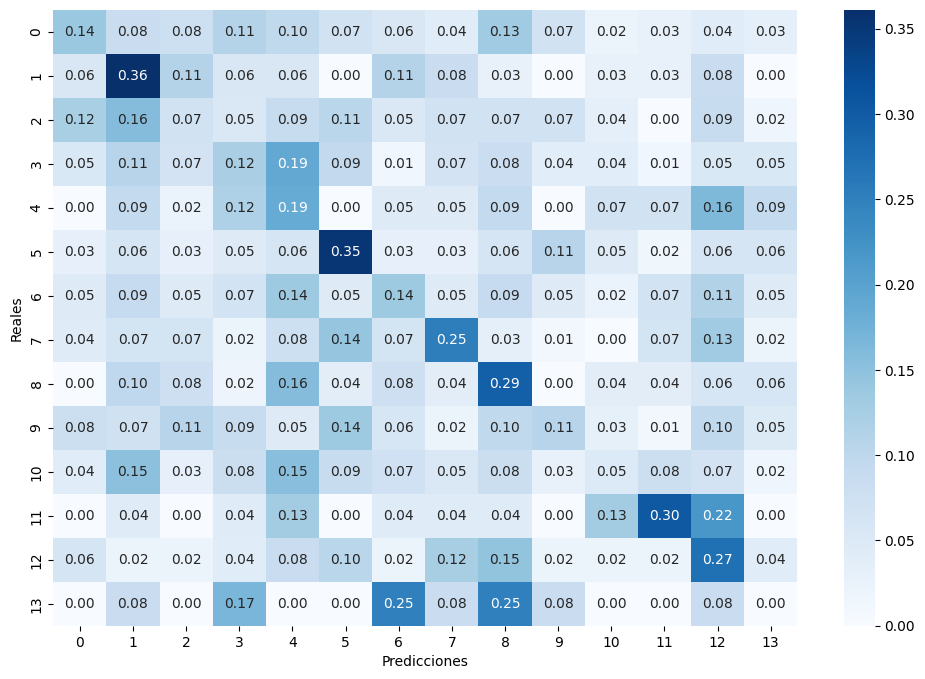

Matriz de Confusión Normalizada (por fila)
Modelo KerasClassifier (GRUPOREFERENCIA)


In [33]:
conf_matrix_normalized_sn(y_test, y_pred)
print("Matriz de Confusión Normalizada (por fila)\nModelo KerasClassifier (GRUPOREFERENCIA)")

## **17- Entrenamiento final con todos los datos X:**

In [34]:
from sklearn.base import clone

best_model = search.best_estimator_

# Obtener los parámetros originales del SMOTE del mejor modelo
original_blsmote = best_model.named_steps['smote']

# Recalcular k_neighbors y sampling_strategy con TODOS los datos
X_full = pd.concat([X_train, X_test], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)
y_full_counts = Counter(y_full["GRUPOREFERENCIA"].to_list())

# Ajustar parámetros de BorderlineSMOTE para el dataset completo
n_splits = cv.get_n_splits() if hasattr(cv, "n_splits") else 5  # Asumir 5 folds si no está disponible
adjusted_min_samples = max(1, int(min(y_full_counts.values()) * (n_splits - 1) // n_splits))
safe_k_full = max(1, adjusted_min_samples - 1)

# Clonar y actualizar el modelo con nuevos parámetros de SMOTE
final_model = clone(best_model)
final_model.named_steps['smote'].set_params(
    sampling_strategy={cls: max(count, safe_k_full + 1) for cls, count in y_full_counts.items()},
    k_neighbors=safe_k_full
)

SMOTE(k_neighbors=45, random_state=7,
      sampling_strategy={0: 718, 1: 180, 2: 285, 3: 371, 4: 217, 5: 323, 6: 222,
                         7: 458, 8: 256, 9: 1438, 10: 1809, 11: 115, 12: 240,
                         13: 58})

In [ ]:
# Entrenar con todos los datos (sin estratificación)
final_model.fit(X_full, y_full["GRUPOREFERENCIA"].values)

## **18- Guardar modelo final:**

In [36]:
joblib.dump(final_model, os.path.join(basedir, './models/best_model_KerasClassifier_final.pkl'))

['/home/misc1/./models/best_model_KerasClassifier_final.pkl']

## **19- Predicción con el modelo final:**

In [37]:
X_test.iloc[7:8]

,FAMI_TIENECOMPUTADOR,ESTU_GENERO,FAMI_TIENESERVICIOTV,FAMI_TIENEINTERNET,FAMI_TIENEHORNOMICROOGAS,FAMI_TIENELAVADORA,FAMI_ESTRATOVIVIENDA,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,FAMI_PERSONASHOGAR,EDAD,LAT_COLE,LON_COLE,PUNT_LECTURA_CRITICA,PUNT_MATEMATICAS,PUNT_SOCIALES_CIUDADANAS,PUNT_C_NATURALES,PUNT_INGLES
579,NO,F,NO,NO,NO,NO,ESTRATO 1,SECUNDARIA (BACHILLERATO) INCOMPLETA,PRIMARIA INCOMPLETA,3 A 4,16.0,0.829022,-77.629513,55.0,67.0,64.0,63.0,49.0


In [38]:
model = joblib.load(os.path.join(basedir, './models/best_model_KerasClassifier_final.pkl'))
model.predict(X_test.iloc[7:8])

1/1 - 0s - 86ms/step


2025-06-16 01:35:15.032658: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


array([3])